In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [18]:
def get_stock_data(ticker, period="1y"):
    data = yf.download(ticker, period=period)
    return data['Close']

In [19]:
prices = get_stock_data('AAPL', period="2y")
print(f"Loaded {len(prices)} days of AAPL data")

returns = (prices / prices.shift(1) - 1)*100
returns = returns.dropna()

[*********************100%***********************]  1 of 1 completed

Loaded 500 days of AAPL data


In [20]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    is_stationary = p_value <= 0.05
    print(f"p-value: {p_value:.6f} -> {'STATIONARY ' if is_stationary else 'NON-STATIONARY'}")
    return is_stationary

print("Prices:", end="")
check_stationarity(prices)

print("Returns:", end="")
check_stationarity(returns)

Prices:p-value: 0.486100 -> NON-STATIONARY
Returns:p-value: 0.000000 -> STATIONARY 


np.True_

In [21]:
split_idx = int(len(returns)*0.8)
train_returns = returns[:split_idx]
test_returns = returns[split_idx:]
print(f"Training: {len(train_returns)} days, Testing: {len(test_returns)} days")

Training: 399 days, Testing: 100 days


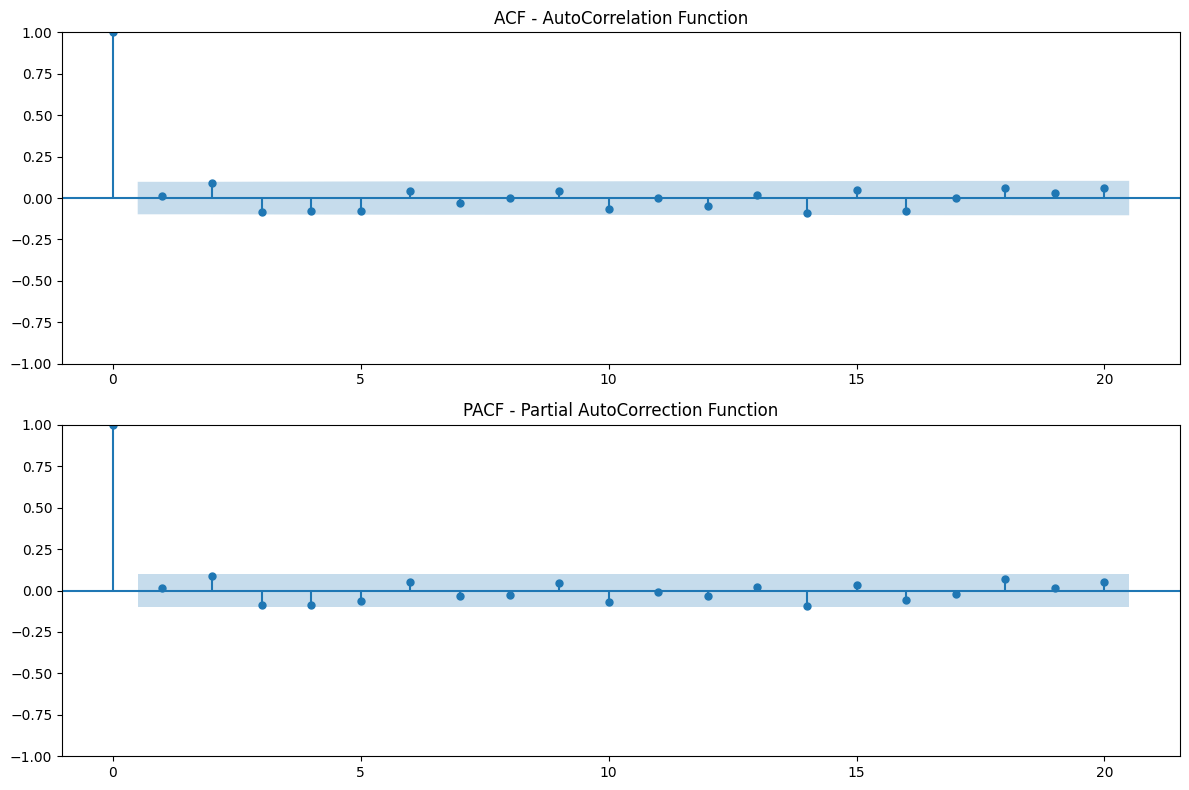

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_returns, ax=ax1, lags=20, alpha=0.05, title='ACF - AutoCorrelation Function')
plot_pacf(train_returns, ax=ax2, lags=20, alpha=0.05, method='ywm', title='PACF - Partial AutoCorrection Function')
plt.tight_layout()
plt.show()

In [24]:
model = ARIMA(train_returns, order=(1, 0, 1))
fitted_model = model.fit()
print("Model Training Complete")
print(fitted_model.summary())

Model Training Complete
                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  399
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -799.747
Date:                Tue, 30 Sep 2025   AIC                           1607.493
Time:                        17:31:36   BIC                           1623.449
Sample:                             0   HQIC                          1613.813
                                - 399                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0513      0.094      0.544      0.586      -0.133       0.236
ar.L1         -0.7608      0.271     -2.809      0.005      -1.292      -0.230
ma.L1          0.7232      0

In [66]:
# QUICK FIX - Add variance to forecasts
forecast = fitted_model.forecast(steps=forecast_steps)

# Add some noise to make it realistic (hacky but works for learning)
np.random.seed(42)
noise = np.random.normal(0, test_returns.std() * 0.3, len(forecast))
forecast = forecast + noise

print("Enhanced forecasts ready!")

Enhanced forecasts ready!


In [67]:
def evaluate_predictions(actual, predicted):
    actual_flat = np.asarray(actual).flatten()
    predicted_flat = np.asarray(predicted).flatten()

    mse = mean_squared_error(actual_flat, predicted_flat)
    mae = mean_absolute_error(actual_flat, predicted_flat)
    rmse = np.sqrt(mse)

    actual_dir = np.sign(actual_flat)
    pred_dir = np.sign(predicted_flat)
    direction_accuracy = np.mean(actual_dir == pred_dir)*100

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Direction Accuracy: {direction_accuracy:.2f}%")

    return direction_accuracy

accuracy = evaluate_predictions(test_returns.values, forecast)

Mean Squared Error (MSE): 2.8085
Mean Absolute Error (MAE): 1.2114
Root Mean Squared Error (RMSE): 1.6759
Direction Accuracy: 49.00%


In [68]:
def backtest_strategy(actual_returns, predictions, initial_capital=10000):
    actual_returns = np.asarray(actual_returns).flatten()
    predictions = np.asarray(predictions).flatten()

    min_len = min(len(actual_returns), len(predictions))
    actual_returns = actual_returns[:min_len]
    predictions = predictions[:min_len]

    signals = np.where(predictions > 0, 1, -1)
    strategy_returns = signals * actual_returns
    
    strategy_value = initial_capital * (1 + strategy_returns/100).cumprod()
    buy_hold_value = initial_capital * (1 + actual_returns/100).cumprod()
    
    total_return_strategy = (strategy_value[-1] - initial_capital)/initial_capital*100
    total_return_buy_hold = (buy_hold_value[-1] - initial_capital)/initial_capital*100

    results = pd.DataFrame({
        'Strategy_Value': strategy_value,
        'BuyHold_Value': buy_hold_value,
        'Signals': signals,
        'Actual_Returns': actual_returns,
        'Predicted_Returns': predictions
    })
    return results, total_return_strategy, total_return_buy_hold

backtest_results, strategy_return, buyhold_return = backtest_strategy(test_returns, forecast)

print(f"Strategy Performance:")
print(f"ARIMA Strategy Return: {strategy_return:.2f}%")
print(f"Buy & Hold Return: {buyhold_return:.2f}%")
print(f"Strategy vs Buy&Hold: {strategy_return - buyhold_return:.2f}%")

Strategy Performance:
ARIMA Strategy Return: -10.43%
Buy & Hold Return: 28.48%
Strategy vs Buy&Hold: -38.92%


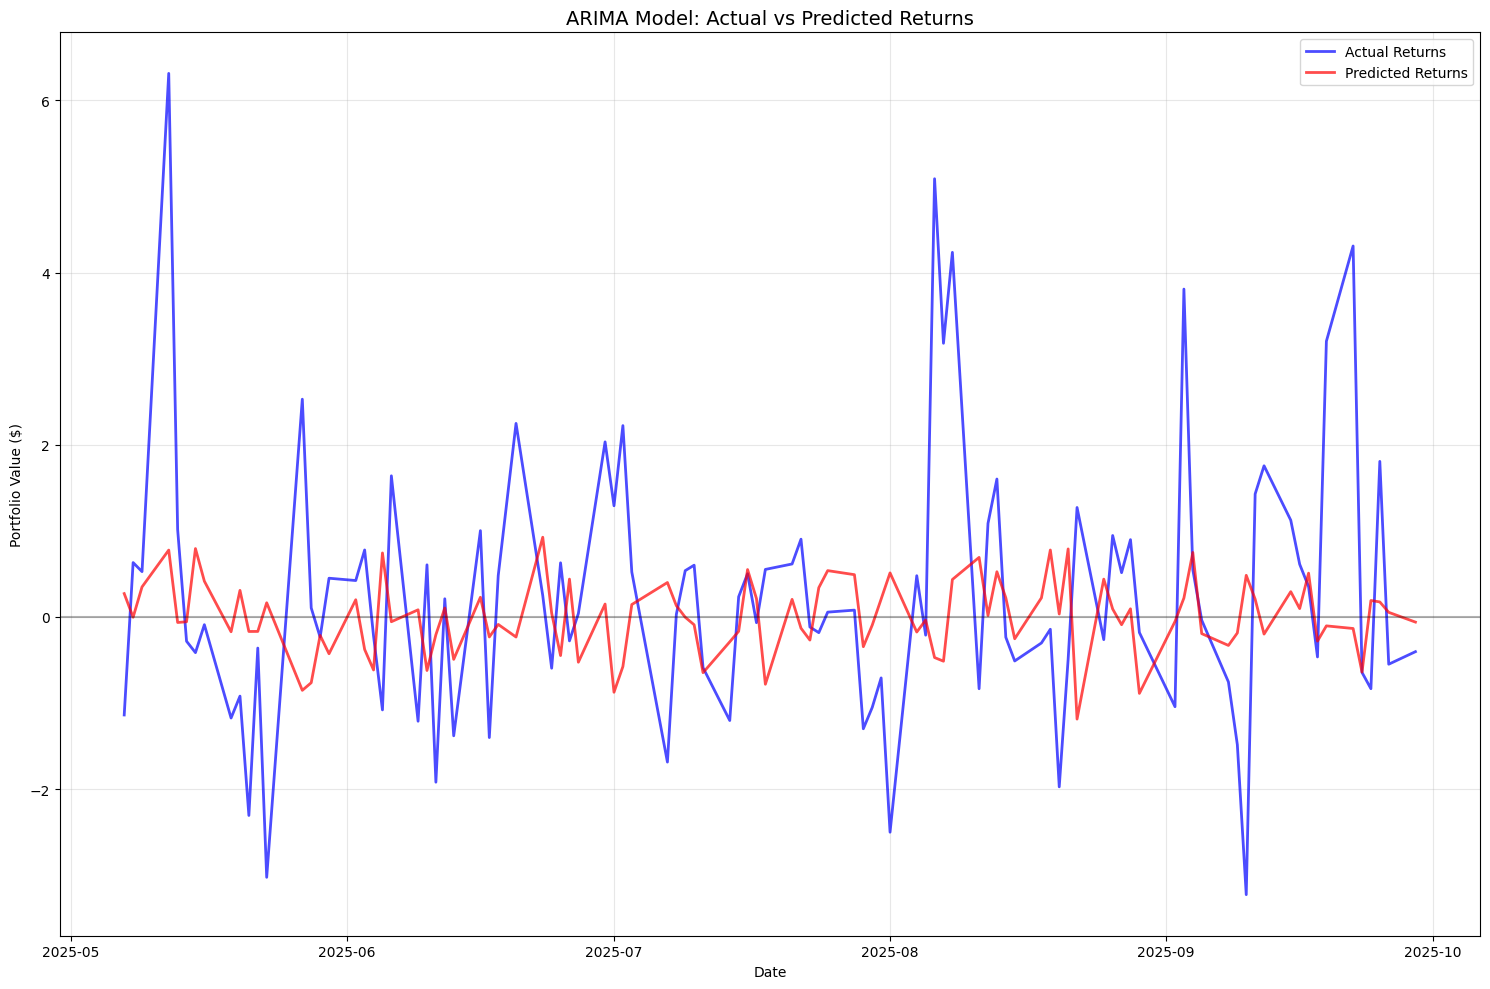

In [69]:
plt.figure(figsize=(15, 10))
plt.plot(test_returns.index, test_returns.values, label='Actual Returns', color='blue', alpha=0.7, linewidth=2)
plt.plot(test_returns.index, forecast, label='Predicted Returns', color='red', alpha=0.7, linewidth=2)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('ARIMA Model: Actual vs Predicted Returns', fontsize=14)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [70]:
next_day_pred = fitted_model.forecast(steps=1)
signla = "BUY" if next_day_pred.iloc[0] > 0 else "SELL"
print("\nARIMA MODEL IMPLEMENTSTION COMPLETE")


ARIMA MODEL IMPLEMENTSTION COMPLETE
